In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, optimizers, Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('dataset/collected_data_0812_1_3K.csv')
# df['datetime'] = pd.to_datetime(df['datetime'])
df.drop(columns = ['robot_status', 'robot_mode', 'safety_mode', 'payload', 'Unnamed: 0', 'datetime', 'uptime', '0ac_qd', '0tg_qdd', '1jc_current', '1ac_current', '1j_volt', '1j_temp', '2j_temp', '2ac_tcp_force', '2ac_tcp_pos', '2ac_qd', '2tg_qdd', 't0', 'a1', 't1', 't2', 't3', 't4', 't5'], inplace = True)
df[df.isna().any(axis=1)] #컬럼이 많을떄 결측치 확인하는 코드 유용띠
data = pd.concat([df, pd.DataFrame(columns=['label'])]).fillna(0)

# corr = data.corr()
# # 상삼각행렬만 남기고, 자기자신(=1)은 제외
# high_corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# # 조건 적용해서 컬럼 쌍 출력
# result = high_corr.stack()[high_corr.stack() > 0.5]
# print(result)

# print(tf.sysconfig.get_build_info()['cuda_version'])
# print(tf.sysconfig.get_build_info()['cudnn_version'])

X = np.array(data.drop(columns = 'label'))
y = np.array(data[['label']])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, shuffle = False, random_state = 42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = False, random_state = 42)

def make_sequences(x_data, y_data, sequences):
    X_seq, y_seq, offset = [], [], 25
    for i in range(len(x_data) - sequences - offset):
        X_seq.append(x_data[i : i + sequences])
        y_seq.append(y_data[i + sequences + offset])

    return np.array(X_seq), np.array(y_seq)

sequence = 10
X_train_sequence, y_train_sequence = make_sequences(X_train, y_train, sequence)
X_test_sequence, y_test_sequence = make_sequences(X_test, y_test, sequence)

# print(X_train_sequence.shape)
# print(y_train_sequence.shape)

def LSTM_AE(sequence, n_features):
    lstm_ae = models.Sequential()

    lstm_ae.add(layers.LSTM(32, input_shape=(sequence, n_features), return_sequences=True))
    lstm_ae.add(layers.LSTM(16, return_sequences=False)) # 
    lstm_ae.add(layers.RepeatVector(sequence)) # 시퀀스 길이 복원

    lstm_ae.add(layers.LSTM(16, return_sequences=True))
    lstm_ae.add(layers.LSTM(32, return_sequences=True))
    lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))
    return lstm_ae

autoencoder = LSTM_AE(10, 45)

autoencoder.summary()

checkpoint = ModelCheckpoint("autoencoder.h5",
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=20, verbose=1)
es = EarlyStopping(monitor='val_loss', min_delta = 0.00001, patience=50, verbose=1, mode='min', restore_best_weights=True)

autoencoder.compile(loss='mse', optimizer=optimizers.Adam(0.00015))

history = autoencoder.fit(X_train_sequence, X_train_sequence, epochs = 800, batch_size = 128, callbacks = [reduce_lr, es, checkpoint], validation_split=0.2, shuffle=False, verbose=1)



In [ ]:
# Printing Trained results
#
print(history.history.keys())
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label ='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
# plt.plot(history.history["accuracy"],label='accuracy')
# plt.plot(history.history["val_accuracy"],label='Validation accuracy')
plt.legend()
plt.show()
print("training loss      :", history.history['loss'][-1])
print("val_loss           :", history.history['val_loss'][-1])
# print("training accuracy  :", history.history['accuracy'][-1])
# print("val_accuracy       :", history.history['val_accuracy'][-1])

reconstructed = autoencoder.predict(X_test_sequence)
Xtst = X_test_sequence.reshape(X_test_sequence.shape[0], X_test_sequence.shape[1]*X_test_sequence.shape[2])
rest = reconstructed.reshape(reconstructed.shape[0], reconstructed.shape[1]*reconstructed.shape[2])
mse = np.mean(np.square(X_test_sequence - reconstructed), axis=1)
plt.figure(figsize=(10, 3))
plt.title("Reconstruction Error Distribution")
#plt.subplot(1,1,1)
threshold = np.percentile(mse,85)
labels = (mse < threshold).astype(int)

plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.hist(mse, bins=100)
plt.show()

reconstruction_errors = mse 

plt.figure(figsize=(10,3))
#plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, c='b', marker='o', label='Reconstruction Error')
plt.plot(reconstruction_errors, c='b', label='Reconstruction Error')
plt.axhline(y=np.mean(reconstruction_errors), color='y', linestyle='-', label='Average')
plt.axhline(y=np.max(reconstruction_errors)*0.9, color='r', linestyle='--', label='90% of MAX')
plt.axhline(y=np.max(reconstruction_errors)*threshold, color='c', linestyle='--', label='threshold')
plt.title('Autoencoder for Anomaly Detection')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

reconstructed = autoencoder.predict(X_test_sequence)

# MSE 계산 (sample별)
mse = np.mean(np.square(X_test_sequence - reconstructed), axis=(1,2))

# 재구성 오차 분포 시각화
plt.figure(figsize=(10,3))
plt.hist(mse, bins=100, color='skyblue')
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()

plt.hist(mse, bins=100)
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


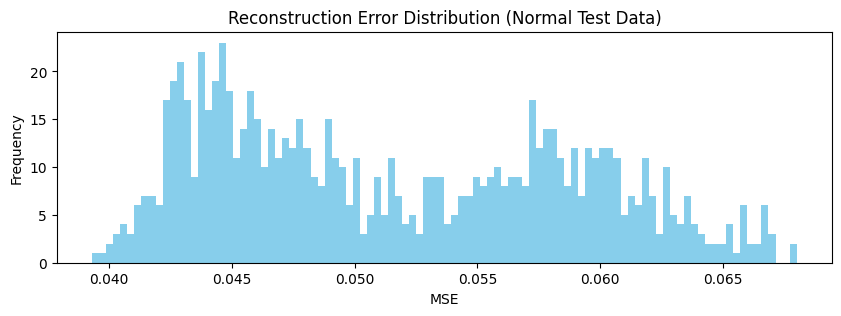

MSE 평균: 0.051598572998891756
MSE 표준편차: 0.007218414886595854
MSE 최대: 0.06799066448964053


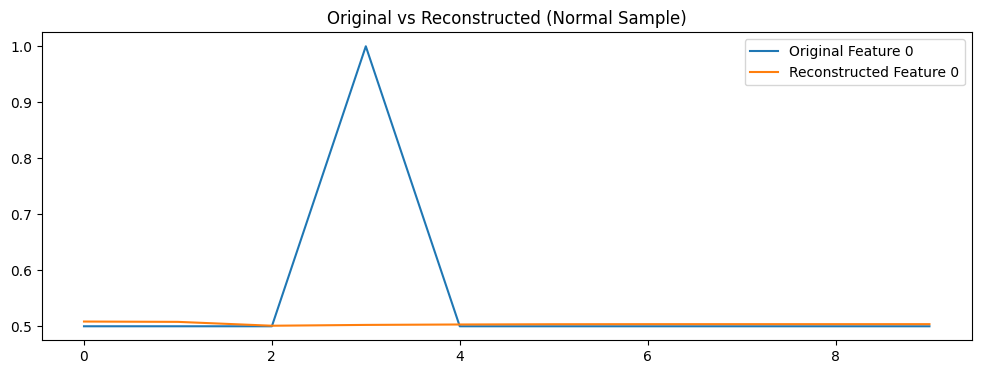

Sample MSE: 0.05986530481767967


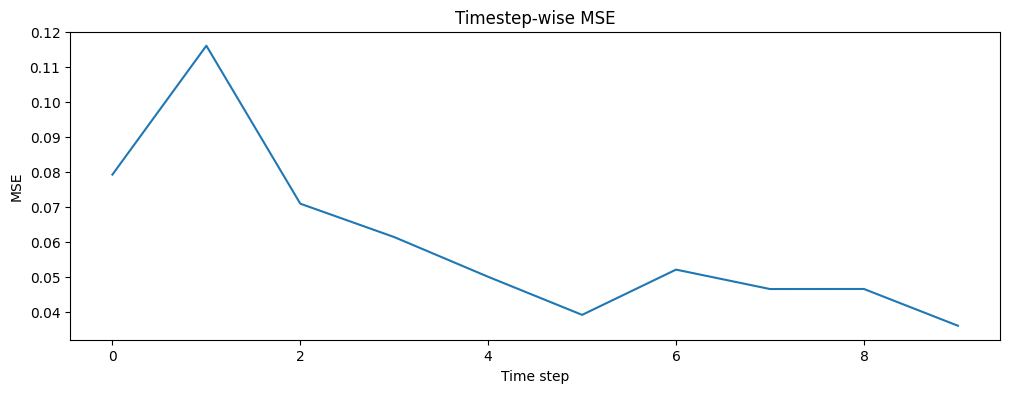

In [135]:
# print("MSE 평균:", mse.mean())
# print("MSE 표준편차:", mse.std())
# print("MSE 최대:", mse.max())

# threshold = np.percentile(mse, 95)  # 상위 15%를 이상치
# labels = (mse > threshold).astype(int)

# print("정상 샘플 수:", np.sum(labels == 0))
# print("이상치 샘플 수:", np.sum(labels == 1))

# plt.figure(figsize=(10,4))
# plt.hist(mse[labels==0], bins=100, alpha=0.7, label='Normal')
# plt.hist(mse[labels==1], bins=100, alpha=0.7, label='Anomaly')
# plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
# plt.title("Anomaly Detection based on Reconstruction Error")
# plt.xlabel("MSE")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()


reconstructed = autoencoder.predict(X_test_sequence)
mse = np.mean(np.square(X_test_sequence - reconstructed), axis=(1,2))

plt.figure(figsize=(10,3))
plt.hist(mse, bins=100, color='skyblue')
plt.title("Reconstruction Error Distribution (Normal Test Data)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.show()

print("MSE 평균:", mse.mean())
print("MSE 표준편차:", mse.std())
print("MSE 최대:", mse.max())

sample_idx = 0  # 확인할 샘플
plt.figure(figsize=(12,4))
plt.plot(X_test_sequence[sample_idx,:,0], label='Original Feature 0')
plt.plot(reconstructed[sample_idx,:,0], label='Reconstructed Feature 0')
plt.title("Original vs Reconstructed (Normal Sample)")
plt.legend()
plt.show()

sample_mse = np.mean((X_test_sequence[sample_idx] - reconstructed[sample_idx])**2)
print("Sample MSE:", sample_mse)

timestep_mse = np.mean((X_test_sequence[sample_idx] - reconstructed[sample_idx])**2, axis=1)
plt.figure(figsize=(12,4))
plt.plot(timestep_mse)
plt.title("Timestep-wise MSE")
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.show()